## Efficient GANの作成
AnoGANの学習と異常検知までに時間がかかるのを解決する

In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


## Generatorの実装

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim=20):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64,
                              kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1, 
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        # Deconv層に入れるためにテンソルの形を整形
        out = out.view(z.shape[0], 128, 7, 7)
        out = self.layer3(out)
        out = self.last(out)
        
        return out

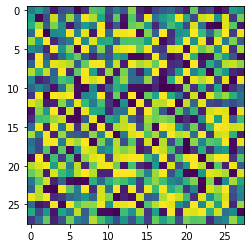

In [15]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20)
G.train()

# バッチノーマライゼーションがあるのでバッチサイズは１以上でないとエラーになる
# ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 1024])
input_z = torch.randn(2, 20)

# 偽画像を出力
fake_images = G(input_z)
image_transformed = fake_images[0][0].detach().numpy()
plt.imshow(image_transformed)  # こっちの色の方
plt.show()

## Discriminatorの実装
今までのGANと違う点
- BiGANになっているので入力画像xだけでなく生成ノイズzも入力する
- 2つの入力は畳み込み層、全結合層で別々に処理された後torch.cat()で結合
- 結合したものを全結合層で処理
<br>AnoGANと同じ点
- 異常度の計算に、最後の識別結果を出力する全結合層の１つ手前の層の特徴量を使用する（別途出力する）

In [18]:
class Discriminator(nn.Module):
    
    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()
        
        # 画像側の入力処理
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))
        
        # 生成乱数側の入力処理
        self.z_layer1 = nn.Linear(z_dim, 512)
        
        # 最後の判定
        self.last1= nn.Sequential(
            nn.Linear(3648, 1024),  # 7*7*64 + 512
            nn.LeakyReLU(0.1, inplace=True))
        
        self.last2 = nn.Linear(1024, 1)  # 最終出力から２値分類したいので１次元に落とす
        
    def forward(self, x, z):
        # 画像側の入力処理
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)
        
        # 生成乱数側の入力処理
        z = z.view(z.shape[0], -1)  # (batch_size, -)
        z_out = self.z_layer1(z)
        
        # x_outとz_outを結合し全結合層で判定
        x_out = x_out.view(-1, 7*7*64)  # 
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)
        
        feature = out
        feature = feature.view(feature.size()[0], -1)
        
        out = self.last2(out)
        
        return out, feature

In [22]:
# 動作確認
D = Discriminator(z_dim=20)
# こちらもx_layer2でBatchNormあるので２以上にする
input_z = torch.randn(2, 20)
fake_images = G(input_z)
d_out, feature = D(fake_images, input_z)  # BiGANなので画像と生成ノイズ入れる

# 出力にSigmoidをかけて0-1に変換
print(nn.Sigmoid()(d_out))
print(feature.shape)

tensor([[0.4832],
        [0.4550]], grad_fn=<SigmoidBackward>)
torch.Size([2, 1024])


# Encoderの実装
教師画像xから生成ノイズzを作成する<br>
(x, E(x))と(G(z), z)の違いを見破りたいのがDiscriminatorで、区別がつかなくさせたいのがGenerator

In [24]:
class Encoder(nn.Module):
    
    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))
        
        # ここまでで画像のサイズは7*7になっている
        self.last  = nn.Linear(128*7*7, z_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # FCに入れるためにテンソルの形を整形
        out = out.view(-1, 128*7*7)
        out = self.last(out)
        
        return out

In [26]:
# 動作確認
E = Encoder(z_dim=20)

# 入力する画像データ
x = fake_images

# 画像からzをEncode
z = E(x)
print(z.shape)
print(z)


torch.Size([2, 20])
tensor([[-0.0424,  0.4538, -0.5568,  0.1626,  0.2283,  0.0871,  0.7294,  1.0893,
         -0.7978,  0.0960, -0.0376,  0.2664, -0.5727, -0.3135, -0.7745,  0.5290,
         -0.0055,  0.0956, -0.1596, -0.0388],
        [ 0.6065,  0.1608,  0.4253, -0.9233, -0.8063, -0.2744,  0.4433, -0.1404,
         -0.5223, -0.4798,  0.6908, -0.2949,  0.0859,  0.4230,  0.2810,  0.5912,
         -0.4553,  0.0156, -0.0082, -0.3940]], grad_fn=<AddmmBackward>)


## DataLoaderの作成

In [33]:
def make_datapath_list():
    
    # 画像ファイルパス格納用
    train_img_list = []
    
    for img_idx in range(200):
        img_path = './data/img_78_28size/img_7_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = './data/img_78_28size/img_8_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

In [34]:
class ImageTransform():
    """
    画像処理前クラス
    """
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.data_transform(img)

In [38]:
class GAN_Img_Dataset(data.Dataset):
    """
    画像のDatasetクラス
    pytorchのDatasetクラスを継承
    """
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        """
        画像の枚数を返す
        """
        return len(self.file_list)
    
    def __getitem__(self, index):
        """
        前処理した画像のTensor形式のデータを取得
        """
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        return img_transformed

In [39]:
# DataLoaderの作成と動作確認
train_img_list = make_datapath_list()

mean, std = (0.5, ), (0.5, )
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

batch_iter = iter(train_dataloader)
images = next(batch_iter)
print(images.size())

torch.Size([64, 1, 28, 28])


## 学習させる

In [43]:
def train_model(G, D, E, dataloader, num_epochs):
    
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    
    # 最適化手法の設定
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1,beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # 誤差関数を定義
    # BCEWithLoigtsLossは勝手に入力にsigmoidかけてバイナリクロスエントロピーを計算
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    z_dim = 20
    mini_batch_size = 64
    
    # ネットワークをGPUへ
    G.to(device)
    E.to(device)
    D.to(device)
    
    # 高速化
    torch.backends.cudnn.benchmark = True
    
    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    # batch_sizeはdataloader作るときに指定している
    # インスタンス生成したときにインスタンス変数として保持されている
    batch_size = dataloader.batch_size  
    
    iteration = 1
    # logs = []  # 今回使ってない
    
    # epochのループ
    for epoch in range(num_epochs):
        # 開始時刻とlossの初期化
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_e_loss = 0.0
        epoch_d_loss = 0.0
        
        # 表示
        print('------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('------------')
        print('(train)')
        # mini_batch のループ
        for images in dataloader:
            
            # batchnormエラー回避
            if images.size()[0] == 1:
                continue
            
            # mini_batch_sizeの１もしくは０のラベル役のテンソルを作成
            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = images.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)
            
            # データをGPUへ
            images =images.to(device)
            
            
            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # 真の画像判定
            z_out_real = E(images)
            d_out_read = D(images, z_out_real)  # BiGAN
            
            # 偽画像を生成して判定
            input_z = torch.randn(mini_batch_size. z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)
            
            # 誤差計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            # backpropagation
            # zero_gradしてbackwardしてstep更新する
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            
            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽画像生成して判定
            input_z = torch.randn(mini_batch_size. z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)
            
            # 誤差計算
            g_loss = criterion(d_out_fake.view(-1), label_real)  # label_realとなので注意
            
            # backpropagation
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
    
            
            # --------------------
            # 3. Encoderの学習
            # --------------------
            # 真の画像のzを推定
            z_out_real = E(images)
            d_out_real = D(images, z_out_real)
            
            # 誤差計算
            e_loss = criterion(d_out_real.view(-1), label_fake)
            
            # backpropagation
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()
            
            
            # --------------------
            # 4. 記録
            # --------------------
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            epoch_d_loss += d_loss.item()
            iteration += 1 
            
        # epochの学習時間とlossの表示
        t_epoch_finish = time.time()
        print('------------')
        print('epoch {} || Epoch_D_loss: {:.4f} || Epoch_G_loss: {:.4f} || Epoch_E_loss :{:.4f}'.format(
            epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer : {:.4f} sec'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        
    print('総イテレーション回数：', iteration)
    
    return G, D, E


In [45]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        m.bias.data.fill_(0)
        
# 初期化実施
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print('ネットワークの初期化完了')

ネットワークの初期化完了


In [ ]:
# 学習
num_epochs = 1500
G, D, E  = train_model(G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)


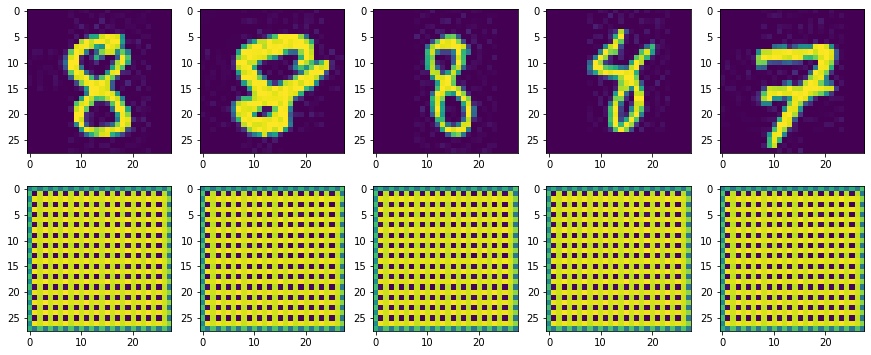

In [49]:
# 生成画像と訓練データを可視化
# ２つの間には何も関係ない
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 入力の乱数生成して学習したGから偽画像を作る
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
G.eval()
fake_images = G(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy())
    
    # 下段に生成データを
    # 未学習だと格子状になる
    plt.subplot(2, 5, i+6)
    plt.imshow(fake_images[i][0].cpu().detach().numpy())

## テスト画像（２）で異常検知

In [55]:
# テスト用DataLoaderの作成
def make_test_datapath_list():
        
    # 画像ファイルパス格納用
    train_img_list = []
    
    for img_idx in range(200):
        img_path = './data/test_28size/img_7_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = './data/test_28size/img_8_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = './data/test_28size/img_2_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
    return train_img_list
    
# ファイルリスト生成
test_img_list = make_test_datapath_list()

# Dataset作成
test_dataset = GAN_Img_Dataset(file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoader作成
batch_size = 5
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

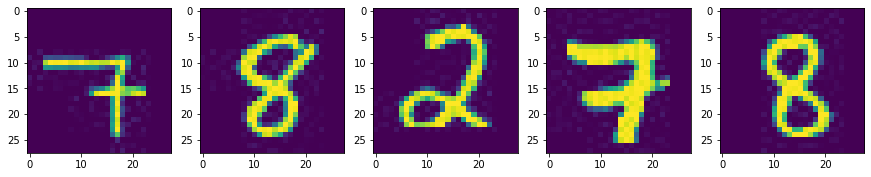

In [58]:
# テストデータの中身確認
batch_iter = iter(test_dataloader)
images = next(batch_iter)

fig = plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy())

In [59]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):
    '''
    
    Parameters:
        x : テスト画像
        fake_img : テスト画像の生成ノイズからGで作成した偽画像
        z_out_real : Encorderにテスト画像を入力して得た生成ノイズ
        '''
    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めてミニバッチ毎庭を求める
    residual_loss = torch.abs(x - fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)
    
    # テスト画像xと生成画像fake_imgを識別機Dに入れ特徴マップを取り出す
    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)
    
    # テスト画像xの特徴量と生成画像fake_imgの特徴量の差の絶対値を求めてミニバッチ毎庭を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    
    # ミニバッチ毎に２種類の損失の足し算
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    # ミニバッチ全体の損失の和
    total_loss = torch.sum(loss_each)
    
    return total_loss, loss_each, residual_loss

In [61]:
# 異常検知したい画像
x = images
x = x.to(device)

# 教師データの画像をエンコードしてzにしてからGで生成
E.eval()
G.eval()
z_out_real = E(images.to(device))
images_reconstract = G(z_out_real)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    x, images_reconstract, z_out_real, D, Lambda=0.1)

# 損失の計算
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

print('total loss: ', loss)

# 画像を可視化
fig = plt.figure(figsize=(15, 6))
for i in range(5):
    # 訓練データ
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy())
    
    # 生成データ
    plt.subplot(2, 5, i+6)
    plt.imshow(images_reconstract[i][0].cpu().detach().numpy())

False